# Notebook to plot HNL constraints

This notebook computes some low-level quantities that might be of interest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import interpolate

from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import pathos.multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

from functools import partial

from particle import *
from particle import literals as lp

In [146]:
from hnl_apps import model
from hnl_apps import hnl_tools
from hnl_apps.plot_tools import *
from hnl_apps import exp
from hnl_apps.const import *

## Neutrino fluxes 

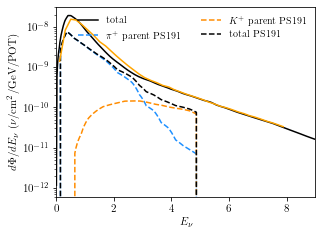

In [152]:
nd280fhc = exp.experiment(exp.PS191)
fpi = nd280fhc.get_flux_func(parent=lp.pi_plus)
fK = nd280fhc.get_flux_func(parent=lp.K_plus)

ps191 = exp.experiment(exp.PS191_proposal)
fpi_ps191 = ps191.get_flux_func(parent=lp.pi_plus)
fK_ps191 = ps191.get_flux_func(parent=lp.K_plus)

fig = plt.figure()
ax = fig.add_axes(axes_form)

x=np.linspace(0,20,1000)
# ax.plot(x,fpi(x), label='$\pi^+$ parent T2K', c='dodgerblue')
# ax.plot(x,fK(x), label='$K^+$ parent T2K', c='darkorange')
ax.plot(x,fpi(x) + fK(x), label='total', c='black')

ax.plot(x,fpi_ps191(x), label='$\pi^+$ parent PS191', ls='--', c='dodgerblue')
ax.plot(x,fK_ps191(x), label='$K^+$ parent PS191', ls='--', c='darkorange')
ax.plot(x,fpi_ps191(x) + fK_ps191(x), label='total PS191', ls='--', c='black')

e,f=np.genfromtxt("hnl_apps/fluxes/ps191/numu_flux.dat",unpack=True)
f *= 1/0.2/(3*6)/1e4/0.89e19
ax.plot(e,f, c='orange')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')
ax.legend(loc='upper right', frameon=False, ncol=2)
ax.patch.set_facecolor('None')
ax.set_xlim(0,9)
# ax.set_ylim(1e-12,1e-7)
fig.savefig("plots/nd280_FHC_nufluxes.png", dpi=400)


### mean neutrino energy of PS191 and T2K

In [183]:
print(np.average(x,weights=fpi(x)+fK(x)))
print(np.average(x,weights=fpi_ps191(x)+fK_ps191(x)))

1.016437988177534
1.016437988177534


## Shrock's Function

/Users/matheushostert/Repos/stdHNL/hnl_apps/const.py:144: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))
/Users/matheushostert/Repos/stdHNL/hnl_apps/const.py:144: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))
/Users/matheushostert/Repos/stdHNL/hnl_apps/const.py:144: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))


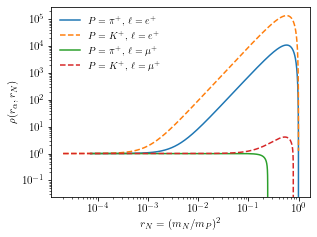

In [153]:
mN_K = np.logspace(-5,np.log10(lp.K_plus.mass/1e3),10000, endpoint=False)
mN_pi = np.logspace(-5,np.log10(lp.pi_plus.mass/1e3),10000, endpoint=False)

fig = plt.figure()
ax = fig.add_axes(axes_form)

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), hnl_tools.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.e_plus), label=r'$P=\pi^+,\,\ell=e^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), hnl_tools.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.e_plus), label=r'$P=K^+,\,\ell=e^+$',ls='--')

ax.plot(mN_pi/(lp.pi_plus.mass/1e3), hnl_tools.get_Rapp(mN_pi, parent = lp.pi_plus, daughter = lp.mu_plus), label=r'$P=\pi^+,\,\ell=\mu^+$')
ax.plot(mN_K/(lp.K_plus.mass/1e3), hnl_tools.get_Rapp(mN_K, parent = lp.K_plus, daughter = lp.mu_plus), label=r'$P=K^+,\,\ell=\mu^+$',ls='--')

ax.set_ylabel(r"$\rho(r_\alpha,r_N)$")
ax.set_xlabel(r"$r_N=(m_N/m_P)^2$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc='upper left', frameon=False)
ax.patch.set_facecolor('None')
fig.savefig("plots/rho_function.png", dpi=400)

## Approximation for HNL flux

/Users/matheushostert/Repos/stdHNL/hnl_apps/const.py:144: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))


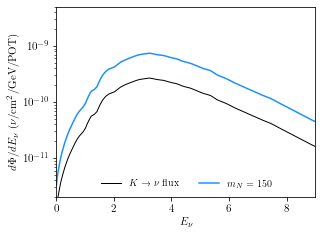

In [154]:
fig = plt.figure()
ax = fig.add_axes(axes_form)
USQR = 1

x=np.linspace(0,10,1000)

#\nu 
ax.plot(x,fK(x), label=r'$K\to\nu$ flux', color= 'black', lw = 1)
# ax.plot(x,fK(x), label=r'$K^+$ parent', color='orange')

MN = 0.150

ps191 = exp.experiment(exp.PS191)
fpi_ps191 = ps191.get_flux_func(parent=lp.pi_plus)
fK_ps191 = ps191.get_flux_func(parent=lp.K_plus)

# aux_dEN = np.array([2*EN[0] - EN[1]]+EN.tolist()+[2*EN[-1] - EN[-2]])
# dEN = (aux_dEN[2:]-aux_dEN[:-2])/2

phiN_pi = hnl_tools.dphi_dEN_app(fpi_ps191, x, Ualpha4SQR=USQR, mN=MN, parent=lp.pi_plus, daughter=lp.mu_plus)
phiN_K = hnl_tools.dphi_dEN_app(fK_ps191, x, Ualpha4SQR=USQR, mN=MN, parent=lp.K_plus, daughter=lp.mu_plus)
# ax.plot(x,phiN_pi, label=r'$\pi^+ \to \mu^+ N$', ls='--', color= 'dodgerblue')
ax.plot(x,phiN_K, label=r'$m_N = 150$', ls='-', color='dodgerblue')


ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')
ax.set_ylim(2e-12,5e-9)
ax.set_xlim(0,9)
ax.legend(loc='lower center', frameon=False, ncol=2)
ax.patch.set_facecolor('None')
fig.savefig("plots/HNL_fluxes_mN_150_ps191.png", dpi=400)

M_N = 0.15, T2K = 3e-09, Matheus = 2.8e-09, ratio = 0.95
M_N = 0.25, T2K = 8.5e-09, Matheus = 4.2e-09, ratio = 0.49


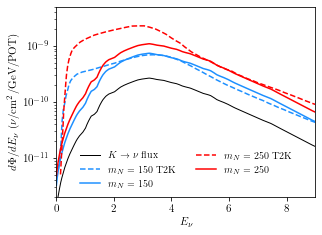

In [155]:
fig = plt.figure()
ax = fig.add_axes(axes_form)
USQR = 1

x=np.linspace(0,10,1000)

#\nu 
ax.plot(x,fK(x), label=r'$K\to\nu$ flux', color= 'black', lw = 1)
# ax.plot(x,fK(x), label=r'$K^+$ parent', color='orange')

MN = 0.150

EN, flux = np.genfromtxt("digitized/T2K_HNL_fluxes/m4_150_MeV_KmuN.dat", unpack = True)
ax.plot(EN,USQR*flux/1e21, label=r'$m_N = 150$ T2K', ls='--', color='dodgerblue')

aux_dEN = np.array([2*EN[0] - EN[1]]+EN.tolist()+[2*EN[-1] - EN[-2]])
dEN = (aux_dEN[2:]-aux_dEN[:-2])/2

# phiN_pi = hnl_tools.dphi_dEN_app(fpi, x, Ualpha4SQR=USQR, mN=MN, parent=lp.pi_plus, daughter=lp.mu_plus)
phiN_K = hnl_tools.dphi_dEN_app(fK, x, Ualpha4SQR=USQR, mN=MN, parent=lp.K_plus, daughter=lp.mu_plus)
# ax.plot(x,phiN_pi, label=r'$\pi^+ \to \mu^+ N$', ls='--', color= 'dodgerblue')
ax.plot(x,phiN_K, label=r'$m_N = 150$', ls='-', color='dodgerblue')

print(f'M_N = {MN}, T2K = {USQR*(flux*dEN).sum()/1e21:.2g}, '+\
      f'Matheus = {(x[1]-x[0])*phiN_K.sum():.2g}, '+\
      f'ratio = {(x[1]-x[0])*phiN_K.sum()/(USQR*(flux*dEN).sum()/1e21):.2g}')

      
MN = 0.250

EN, flux = np.genfromtxt("digitized/T2K_HNL_fluxes/m4_250_MeV_KmuN.dat", unpack = True)
ax.plot(EN,USQR*flux/1e21, label=r'$m_N = 250$ T2K', ls='--', color='red')

aux_dEN = np.array([2*EN[0] - EN[1]]+EN.tolist()+[2*EN[-1] - EN[-2]])
dEN = (aux_dEN[2:]-aux_dEN[:-2])/2

# phiN_pi = hnl_tools.dphi_dEN_app(fpi, x, Ualpha4SQR=USQR, mN=MN, parent=lp.pi_plus, daughter=lp.mu_plus)
phiN_K = hnl_tools.dphi_dEN_app(fK, x, Ualpha4SQR=USQR, mN=MN, parent=lp.K_plus, daughter=lp.mu_plus)
# ax.plot(x,phiN_pi, label=r'$\pi^+ \to \mu^+ N$', ls='--', color= 'dodgerblue')
ax.plot(x,phiN_K, label=r'$m_N = 250$', ls='-', color='red')


print(f'M_N = {MN}, T2K = {USQR*(flux*dEN).sum()/1e21:.2g}, '+\
      f'Matheus = {(x[1]-x[0])*phiN_K.sum():.2g}, '+\
      f'ratio = {(x[1]-x[0])*phiN_K.sum()/(USQR*(flux*dEN).sum()/1e21):.2g}')

ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"$d\Phi/dE_\nu$ ($\nu$/cm$^2$/GeV/POT)")
ax.set_yscale('log')
ax.set_ylim(2e-12,5e-9)
ax.set_xlim(0,9)
ax.legend(loc='lower center', frameon=False, ncol=2)
ax.patch.set_facecolor('None')
fig.savefig("plots/HNL_fluxes_mN_150.png", dpi=400)

## Decay Rates

### Ue4 mixing only

No handles with labels found to put in legend.


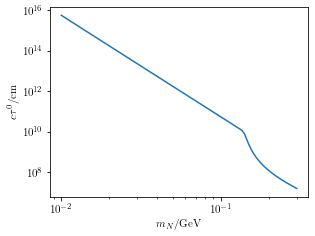

In [158]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-6
ctaus=[]
for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[USQR,0, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    ctaus.append(my_hnl.ctau0)
ctaus=np.array(ctaus)

# Plotting
fig = plt.figure()
ax = fig.add_axes(axes_form)

ax.plot(M4,ctaus)
 
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"$c\tau^0/$cm")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/lifetime_e-only.png", dpi=400)

In [159]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.4),100)
USQR = 1e-2

list_of_channels = ['nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[USQR,0.0, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

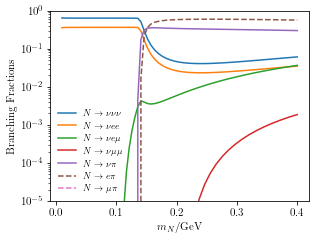

In [160]:
fig = plt.figure()
ax = fig.add_axes(axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_e-only.png", dpi=400)

### Umu4

In [161]:
my_hnl = model.hnl_model(m4=0.350, mixings=[0.0,1.0, 0.0])
my_hnl.set_high_level_variables()
my_hnl.compute_rates()
print(my_hnl.ctau0,my_hnl.rates['nu_pi'])

10.99426987510873 7.105760785812711e-16


In [162]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),100)
USQR = 1e-4
ctaus=[]
for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,USQR, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    ctaus.append(my_hnl.ctau0)
ctaus=np.array(ctaus)

No handles with labels found to put in legend.


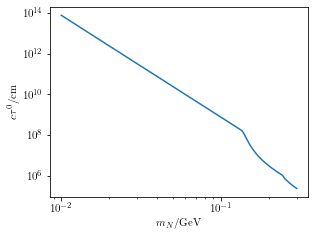

In [163]:
fig = plt.figure()
ax = fig.add_axes(axes_form)

ax.plot(M4,ctaus)
 
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"$c\tau^0/$cm")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-5,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/lifetime_mu-only.png", dpi=400)

In [164]:
# Compute all the decay rates and branching ratios
M4=np.logspace(-2,np.log10(0.300),200)
USQR = 1e-2

list_of_channels = ['nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,USQR, 0.0])
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

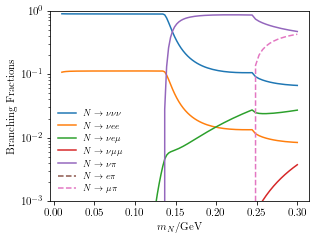

In [165]:
fig = plt.figure()
ax = fig.add_axes(axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-3,1)
ax.legend(loc='lower left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_mu-only.png", dpi=400)

### Turning on the dipole at the top tip of the Supernova bound

In [170]:
USQR = 1e-14
dmu4=5e-7
my_hnl = model.hnl_model(m4=0.250, mixings=[0.0,USQR, 0.0], dipoles=[0.0, dmu4, 0.0], GX= 0*Gf, )
my_hnl.set_high_level_variables()
my_hnl.compute_rates()
print(my_hnl.brs['nu_e_e'])
print(my_hnl.brs['nu_mu_mu'])
print(my_hnl.rates['nu_e_e']/my_hnl.rates['nu_mu_mu'])

0.0072146630367742335
4.0907784467709285e-06
1763.6406201536422


In [171]:
# Compute all the decay rates and branching ratios
M4=np.linspace(0.01,0.5,1000)
USQR = 1e-6
dmu4 = 5e-7 # GeV^-1

list_of_channels = ['nu_gamma','nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,USQR, 0.0], dipoles=[0.0, dmu4, 0.0], GX= 0*Gf)
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

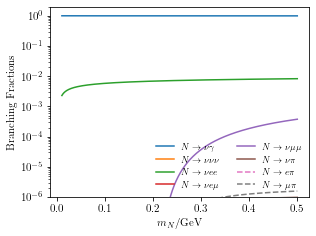

In [172]:
fig = plt.figure()
ax = fig.add_axes(axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi').replace("gamma", '\\gamma')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-6,2)
ax.legend(loc='lower right', frameon=False, ncol=2,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_mudipole.png", dpi=400)

### Now turning on the dark Z'

In [173]:
# Compute all the decay rates and branching ratios
M4=np.linspace(0.15,0.4,1000)
USQR = 1e-4

list_of_channels = ['nu_gamma','nu_nu_nu','nu_e_e','nu_e_mu','nu_mu_mu','nu_pi','e_pi','mu_pi']
all_brs = np.empty((len(list_of_channels),len(M4)))

for j in range(len(M4)):
    my_hnl = model.hnl_model(m4=M4[j], mixings=[0.0,USQR, 0.0], dipoles=[0.0, 0.0, 0.0], GX= 100*Gf)
    my_hnl.set_high_level_variables()
    my_hnl.compute_rates()
    for channel in list_of_channels:
        i = list_of_channels.index(channel)
        
        if channel in my_hnl.brs:
            all_brs[i,j] = my_hnl.brs[channel]
        else:
            all_brs[i,j] = 0.0

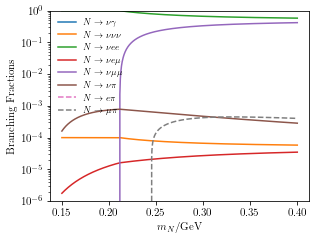

In [175]:
fig = plt.figure()
ax = fig.add_axes(axes_form)

for channel in list_of_channels:
    i = list_of_channels.index(channel)
    label=f'$N\\to {channel}$'.replace("_", " ").replace("nu", '\\nu').replace("mu", '\\mu').replace("pi", '\\pi').replace("gamma", '\\gamma')
    
    if channel[:2] != "nu":
        s='--'
    else:
        s='-'
    
    ax.plot(M4, all_brs[i,:], label=label, linestyle=s)
            
ax.set_xlabel(r"$m_N$/GeV")
ax.set_ylabel(r"Branching Fractions")
ax.set_yscale('log')
ax.set_ylim(1e-6,1)
ax.legend(loc='upper left', frameon=False, ncol=1,fontsize=9)
ax.patch.set_facecolor('None')
fig.savefig("plots/Branching_ratios_mu_Gx.png", dpi=400)

### Compute number of decays in TPCs

In [176]:
# tests
rate_d=[]
rate_gx=[]
rate_d_PS191=[]
rate_gx_PS191=[]
dipole_range=np.logspace(-12,-1,20)
gx_range=np.logspace(-1,4,20)
for d in dipole_range:
    rate_d.append(hnl_tools.get_event_rate((0.1, 1e-6), flavor_struct=[0.0,1.0,0.0], dipoles=[0.0,d,0.0], GX=0, exp_setup=exp.ND280_FHC))
    rate_d_PS191.append(hnl_tools.get_event_rate((0.1, 1e-6), flavor_struct=[0.0,1.0,0.0], dipoles=[0.0,d,0.0], GX=0, exp_setup=exp.PS191))
for gx in gx_range:
    rate_gx.append(hnl_tools.get_event_rate((0.1, 1e-6), flavor_struct=[0.0,1.0,0.0], dipoles=[0.0,0.0,0.0], GX=gx*Gf, exp_setup=exp.ND280_FHC))
    rate_gx_PS191.append(hnl_tools.get_event_rate((0.1, 1e-6), flavor_struct=[0.0,1.0,0.0], dipoles=[0.0,0.0,0.0], GX=gx*Gf, exp_setup=exp.PS191))


(1e-05, 10000000000.0)

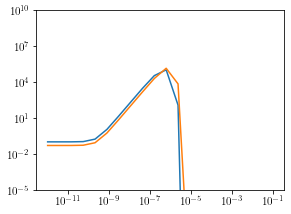

In [181]:
plt.loglog(dipole_range, rate_d)
plt.loglog(dipole_range, rate_d_PS191)
plt.ylim(1e-5,1e10)

(0.0001, 10000000000.0)

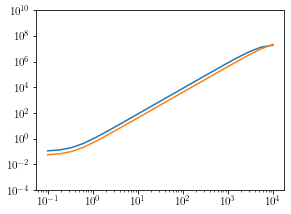

In [180]:
plt.loglog(gx_range, rate_gx)
plt.loglog(gx_range, rate_gx_PS191)
plt.ylim(1e-4,1e10)

### check of HNL bound in comparison to scalar bound

In [148]:
# check of PS191 bound

M = 0.10
GammaN = Gf**2*M**5/192/np.pi**3
GammaPhi= M*m_e**2*Gf/4/np.sqrt(2)/np.pi
BrKmu=0.64
BrKpi=1.4e-3

R=(3e-7)**2*(BrKmu/BrKpi) * (GammaN/GammaPhi)
np.sqrt(R)

2.3422541919564587e-08

In [149]:
# bound on HNLs at T2K at PS191

M = 0.15
GammaN = 1/4*(1-4*s2w+8*s2w**2)*Gf**2*M**5/192/np.pi**3
GammaPhi= M*m_e**2*Gf/4/np.sqrt(2)/np.pi
BrKmu=0.64
BrKpi=1.4e-3

R=(3e-7)**2*(BrKmu/BrKpi)*(GammaN/GammaPhi)
np.sqrt(R)

1.873745373990099e-08